# Instruction-Tuning with LLMs

In [2]:
# !pip install -Uq datasets transformers peft trl evaluate tqdm sacrebleu seaborn pandas matplotlib
# !pip install -Uq torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install --upgrade evaluate
# !pip install trl==0.9.6

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import evaluate
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

from peft import get_peft_model, LoraConfig, TaskType

import pickle
import json
import matplotlib.pyplot as plt

from urllib.request import urlopen
import io

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

CodeAlpaca 20k dataset:

In [5]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WzOT_CwDALWedTtXjwH7bA/CodeAlpaca-20k.json

--2025-07-11 13:29:29--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WzOT_CwDALWedTtXjwH7bA/CodeAlpaca-20k.json
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6957007 (6.6M) [application/json]
Saving to: ‘CodeAlpaca-20k.json.1’

CodeAlpaca-20k.json 100%[===================>]   6.63M  6.82MB/s    in 1.0s    

2025-07-11 13:29:31 (6.82 MB/s) - ‘CodeAlpaca-20k.json.1’ saved [6957007/6957007]



In [6]:
dataset = load_dataset("json", data_files="CodeAlpaca-20k.json", split="train")
dataset

Dataset({
    features: ['output', 'instruction', 'input'],
    num_rows: 20022
})

In [7]:
dataset[1000]

{'output': 's = "Hello world" \ns = s[::-1] \nprint(s)',
 'instruction': 'Reverse the string given in the input',
 'input': 'Hello world'}

 Just focus on the examples that do not have any input:

In [8]:
dataset = dataset.filter(lambda example: example["input"] == '')
# Prevents the model from seeing examples in the same fixed order each time.
dataset = dataset.shuffle(seed=42)

In [9]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']
dataset_split

DatasetDict({
    train: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 7811
    })
    test: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 1953
    })
})

In [10]:
# Select a small set of data for the resource limitation
tiny_test_dataset=test_dataset.select(range(10))
tiny_train_dataset=train_dataset.select(range(10))

## Model and tokenizer

In [11]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left')

In [12]:
tokenizer.eos_token

'</s>'

## Preprocessing the data

In [13]:
def formatting_prompts_func(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (f"### Instruction:\n{mydataset['instruction'][i]}"
                f"\n\n### Response:\n{mydataset['output'][i]}</s>")
        output_texts.append(text)
    return output_texts


def formatting_prompts_func_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (f"### Instruction:\n{mydataset['instruction'][i]}"
                f"\n\n### Response:\n")
        output_texts.append(text)
    return output_texts

In [14]:
expected_outputs = []
instructions_with_responses = formatting_prompts_func(test_dataset)
instructions = formatting_prompts_func_no_response(test_dataset)

for i in tqdm(range(len(instructions_with_responses))):
    tokenized_instruction_with_response = tokenizer(instructions_with_responses[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction = tokenizer(instructions[i], return_tensors="pt")
    expected_output = tokenizer.decode(tokenized_instruction_with_response['input_ids'][0][len(tokenized_instruction['input_ids'][0])-1:], skip_special_tokens=True)
    expected_outputs.append(expected_output)

100%|██████████| 1953/1953 [00:01<00:00, 1207.48it/s]


In [15]:
print('Instructions:\n' + instructions[0] + "-------")
print('Instructions_with_responses:\n' + instructions_with_responses[0]+"-------")
print('Expected_outputs' + expected_outputs[0]+"-------")

Instructions:
### Instruction:
Name the most important benefit of using a database system.

### Response:
-------
Instructions_with_responses:
### Instruction:
Name the most important benefit of using a database system.

### Response:
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.</s>-------
Expected_outputs
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.-------


convert the instructions list into a torch `Dataset`:

In [16]:
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]

instructions_torch = ListDataset(instructions)

## Test the base model

In [17]:
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

Device set to use cpu


Due to resource limitation, only apply the function on 3 records using `instructions_torch[:10]` and `max_length=50`:


In [18]:
# leverages the pre-defined generation pipeline to generate outputs using the model
tokenizer.padding_side = 'left'

with torch.no_grad():
  # len(instructions_torch) = 1953
    pipeline_iterator= gen_pipeline(instructions_torch[:3], max_length=50, early_stopping=True)

generated_outputs_base = []
for text in pipeline_iterator:
    generated_outputs_base.append(text[0]["generated_text"])

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated responses for the whole dataset:

In [19]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VvQRrSqS1P0_GobqtL-SKA/instruction-tuning-generated-outputs-base.pkl')
generated_outputs_base = pickle.load(io.BytesIO(urlopened.read()))

In [20]:
for i in range(1):
    print('Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('------\n')
    print('Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('------\n')
    print('Generated response '+ str(i+1) +': ')
    print(generated_outputs_base[i])
    print('------\n')

Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.

### Response:

------

Expected response 1: 

The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.
------

Generated response 1: 
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.
------



## SacreBLEU score

In [21]:
sacrebleu = evaluate.load("sacrebleu")
results_base = sacrebleu.compute(predictions=generated_outputs_base, references=expected_outputs)
print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
0.0


# Perform instruction fine-tuning with LoRA

In [22]:
lora_config = LoraConfig(r=16, lora_alpha=32, target_modules=["q_proj", "v_proj"],
                         lora_dropout=0.1, task_type=TaskType.CAUSAL_LM)

model = get_peft_model(model, lora_config)

In [23]:
response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

training_args = SFTConfig(output_dir="/tmp", num_train_epochs=10, save_strategy="epoch",
                          fp16=True, per_device_train_batch_size=2, per_device_eval_batch_size=2,
                          max_seq_length=1024, do_eval=True)

trainer = SFTTrainer(model, train_dataset=train_dataset, eval_dataset=test_dataset,
                     formatting_func=formatting_prompts_func, args=training_args,
                     packing=False, data_collator=collator)

#trainer.train()
#log_history_lora = trainer.state.log_history

Map:   0%|          | 0/7811 [00:00<?, ? examples/s]

Map:   0%|          | 0/1953 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [24]:
#trainer.save_model("./instruction_tuning_final_model_lora")

A model that was instruction fine-tuned to the above specifications on a GPU:

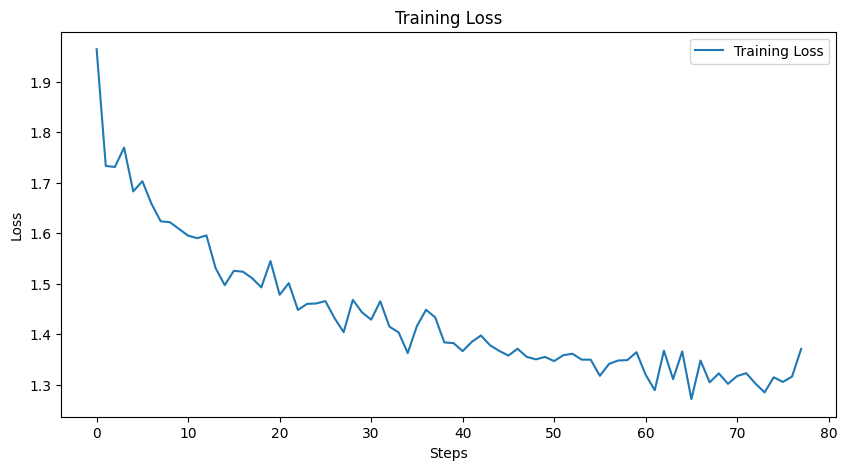

In [25]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/49I70jQD0-RNRg2v-eOoxg/instruction-tuning-log-history-lora.json')
log_history_lora = json.load(io.BytesIO(urlopened.read()))

train_loss = [log["loss"] for log in log_history_lora if "loss" in log]

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [26]:
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

with torch.no_grad():
    pipeline_iterator= gen_pipeline(instructions_torch[:3],
                                max_length=50,
                                num_beams=5,
                                early_stopping=True,)
generated_outputs_lora = []
for text in pipeline_iterator:
    generated_outputs_lora.append(text[0]["generated_text"])


# generated texts for the entire dataset from the fine-tuned LoRA model and run on GPU:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o7uYxe15xvX4CN-6Lr10iA/instruction-tuning-generated-outputs-lora.pkl')
generated_outputs_lora = pickle.load(io.BytesIO(urlopened.read()))

Device set to use cpu


In [27]:
for i in range(1):
    print('Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('------\n')
    print('Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('------\n')
    print('Generated response '+ str(i+1) +': ')
    print(generated_outputs_lora[i])
    print('------\n')

Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.

### Response:

------

Expected response 1: 

The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.
------

Generated response 1: 
The type of data structure to use to store key-value pairs in a Python program would be a key-value pair.
------



In [28]:
sacrebleu = evaluate.load("sacrebleu")
results_lora = sacrebleu.compute(predictions=generated_outputs_lora,
                                 references=expected_outputs)
print(list(results_lora.keys()))
print(round(results_lora["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
1.2


### Try with another response template (Question-Answering)

In [29]:
def formatting_prompts_response_template(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (f"### Question:\n{mydataset['instruction'][i]}"
                f"\n\n### Answer:\n{mydataset['output'][i]}</s>")
        output_texts.append(text)
    return output_texts

def formatting_prompts_response_template_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (f"### Question:\n{mydataset['instruction'][i]}"
                f"\n\n### Answer:\n")
        output_texts.append(text)
    return output_texts

In [30]:
model_name = "EleutherAI/gpt-neo-125m"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [31]:
lora_config = LoraConfig(r=8, lora_alpha=16, target_modules=["q_proj", "v_proj"],
                         lora_dropout=0.1,
                         task_type=TaskType.CAUSAL_LM)

In [32]:
model = get_peft_model(model, lora_config)